<h1 style="color:rgb(81,183,206);font-size:2.5em;">Skillconnect - Week 2 - Advanced Challenge 2</h1>

**Use popular pretrained architectures for transfer learning and show comparison of results**

# Getting the data

In [8]:
import kaggle
from pathlib import Path

In [17]:
data = Path("./data")
data.mkdir()
kaggle.api.authenticate()
kaggle.api.dataset_download_files("tongpython/cat-and-dog",path=data,quiet=False,unzip=True,force=False)

  0%|          | 0.00/218M [00:00<?, ?B/s]

100%|██████████| 218M/218M [00:53<00:00, 4.28MB/s] 


# Readying the data
- Creating train and test dataloaders.
- Train dataset will have ColorJitter applied to it.

In [174]:
import numpy as np

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage, ToTensor, ColorJitter, CenterCrop, Normalize, Resize, Compose

In [175]:
def get_mean_std(ds):
    """
    Gets mean and std of an ImageFolder (instance) dataset.
    """
    means = []
    stds = []
    for d in ds:
        means.append(d[0].mean(axis=(2,1)).numpy())
        stds.append(d[0].std(axis=(2,1)).numpy())
    mean = np.array(means).mean(axis=0)
    std = np.array(stds).mean(axis=0)
    return mean, std

class CatDogDataset(ImageFolder):
    """
    Custom dataset designed so that images can be viewed.
    """
    def __init__(self,root, mean, std,**kwargs):
        self.class_labels = ['cat','dog']
        self.topil = ToPILImage()
        self.norm = Normalize(mean, std)
        super().__init__(root, **kwargs)
    
    def image(self,idx):
        img, l = super().__getitem__(idx)
        return self.topil(img),self.class_labels[l]
    
    def __getitem__(self,idx):
        item = super().__getitem__(idx)
        return self.norm(item[0]),item[1]

In [178]:
# Takes time to run cause > 8000 images, also there may be a better way to do this
temp_ds = ImageFolder(data/'training_set/training_set',transform=ToTensor())
mean, std = get_mean_std(temp_ds) 
print("mean: ",*mean)
print("std:  ",*std)

mean:  0.48826352 0.45509255 0.4174077
std:   0.22981022 0.22478424 0.22537524


In [179]:
training_transforms = Compose([
    ColorJitter(0.3,0.3,0.3),
    Resize(256),
    CenterCrop(224),
    ToTensor()
])
testing_transforms = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor()
])

ds_train = CatDogDataset(data/'training_set/training_set',mean ,std ,transform=training_transforms)
ds_test = CatDogDataset(data/'test_set/test_set',mean ,std ,transform=testing_transforms)

# Checking some test samples

In [183]:
import matplotlib.pyplot as plt

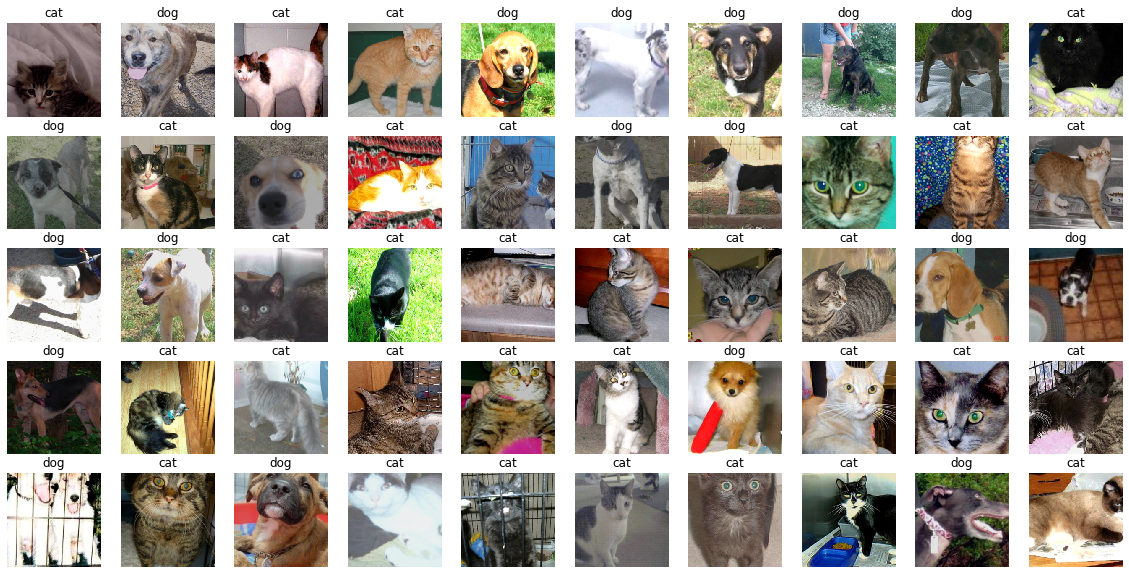

In [194]:
r,c = 5,10
rand_idx = np.random.randint(0,len(ds_train),r*c)

plt.figure(figsize=(20,10))
for i,idx in enumerate(rand_idx):
    img, lbl = ds_train.image(idx)
    plt.subplot(r,c,i+1)
    plt.title(lbl)
    plt.axis('off')
    plt.imshow(img)

___

# Getting Inception Resnet v2
There is no pytorch implementation for this model so getting it from [Cadene/pretrained-models.pytorch](https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/inceptionresnetv2.py)

In [196]:
import requests

In [227]:
irv2_url = "https://raw.githubusercontent.com/Cadene/pretrained-models.pytorch/master/pretrainedmodels/models/inceptionresnetv2.py"
irv2_path = data/"inceptionresnetv2.py"
if not irv2_path.exists():
    content = requests.get(irv2_url).content
    irv2_path.open('w').write(content.decode('utf-8'))

12055

In [231]:
from data.inceptionresnetv2 import inceptionresnetv2
incresnv2 = inceptionresnetv2()

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /Users/alan/.cache/torch/checkpoints/inceptionresnetv2-520b38e4.pth


In [234]:
incresnv2

InceptionResNetV2(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [248]:
incresnv2(ds_test[0][0].unsqueeze(0)).shape

RuntimeError: Given input size: (1536x5x5). Calculated output size: (1536x0x0). Output size is too small

In [238]:
summary(incresnv2,input_size=(3,224,224))

RuntimeError: Given input size: (1536x5x5). Calculated output size: (1536x0x0). Output size is too small

# Loading the models


In [235]:
from torchvision import models

In [236]:
pretrained = False
incresnv2
resnet_50 = models.resnet50(pretrained)
resnext50 = models.resnext50_32x4d(pretrained)
wresnet50 = models.wide_resnet50_2(pretrained)